In [65]:
#Import libraries
import re
import pandas as pd
import nltk
import numpy as np

In [3]:
#Read train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
#Show first 3 rows of train and test data
train.head(3)

,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative


In [5]:
test.head(3)

,textID,text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to..."


# Preprocessing

In [6]:
#Remove entries with no text
train.dropna(subset=['text'], inplace=True)
test.dropna(subset=['text'], inplace=True)

In [7]:
#Replace characters that aren't space or alphanumeric to empty string
train.text = train.text.apply(lambda x: re.sub(r'[^\w\s]','',x))
test.text = test.text.apply(lambda x: re.sub(r'[^\w\s]','',x))

In [8]:
train.head(3)

,textID,text,sentiment
0,cb774db0d1,Id have responded if I were going,neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego,negative
2,088c60f138,my boss is bullying me,negative


In [9]:
test.head(3)

,textID,text
0,f87dea47db,Last session of the day httptwitpiccom67ezh
1,96d74cb729,Shanghai is also really exciting precisely s...
2,eee518ae67,Recession hit Veronique Branquinho she has to ...


In [10]:
#Remove common english words
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
train.text = train.text.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))
test.text = test.text.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))

In [11]:
train.head(3)

,textID,text,sentiment
0,cb774db0d1,Id responded going,neutral
1,549e992a42,Sooo SAD miss San Diego,negative
2,088c60f138,boss bullying,negative


In [12]:
test.head(3)

,textID,text
0,f87dea47db,Last session day httptwitpiccom67ezh
1,96d74cb729,Shanghai also really exciting precisely skyscr...
2,eee518ae67,Recession hit Veronique Branquinho quit compan...


In [13]:
#Remove links
train.text = train.text.apply(lambda x: re.sub(r'\(?http\S+', '', x))
test.text = test.text.apply(lambda x: re.sub(r'\(?http\S+', '', x))

In [14]:
train.head(3)

,textID,text,sentiment
0,cb774db0d1,Id responded going,neutral
1,549e992a42,Sooo SAD miss San Diego,negative
2,088c60f138,boss bullying,negative


In [15]:
test.head(3)

,textID,text
0,f87dea47db,Last session day
1,96d74cb729,Shanghai also really exciting precisely skyscr...
2,eee518ae67,Recession hit Veronique Branquinho quit compan...


In [16]:
#Group similar words together
lemmatizer = nltk.WordNetLemmatizer()

train.text = train.text.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]
))

test.text = test.text.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]
))

In [17]:
train.head(3)

,textID,text,sentiment
0,cb774db0d1,Id responded going,neutral
1,549e992a42,Sooo SAD miss San Diego,negative
2,088c60f138,bos bullying,negative


In [18]:
test.head(3)

,textID,text
0,f87dea47db,Last session day
1,96d74cb729,Shanghai also really exciting precisely skyscr...
2,eee518ae67,Recession hit Veronique Branquinho quit compan...


# Train Multinomial & Gaussian Naive Bayes Sentiment Classifier with CountVectorizer

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [20]:
vectorizer = CountVectorizer()

In [21]:
#Vectorize each time a certain word is used in a text
X = vectorizer.fit_transform(train.text)
Y = vectorizer.transform(test.text)

In [22]:
#Train using Multinomial Naive Bayes model
nb = MultinomialNB()
nb.fit(X, train.sentiment)

MultinomialNB()

In [23]:
#Predict sentiments of test data
predicted = nb.predict(Y)

In [24]:
#Read sample submission
submission = pd.read_csv('sample_submission.csv')

In [25]:
submission.head()

,textID,sentiment
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


In [26]:
#Input predicted sentiments to submission file
submission.sentiment = predicted

In [27]:
submission.head()

,textID,sentiment
0,f87dea47db,positive
1,96d74cb729,positive
2,eee518ae67,negative
3,01082688c6,positive
4,33987a8ee5,neutral


In [28]:
#Turn submission1 to csv file, scored 0.65433 on kaggle
submission.to_csv('submission1.csv', index=False)

In [29]:
#Train using Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X.toarray(), train.sentiment)

GaussianNB()

In [30]:
#Predict sentiments of test data
predicted2 = gnb.predict(Y.toarray())

In [31]:
submission2 = pd.read_csv('sample_submission.csv')

In [32]:
submission2.sentiment = predicted2

In [33]:
submission.head()

,textID,sentiment
0,f87dea47db,positive
1,96d74cb729,positive
2,eee518ae67,negative
3,01082688c6,positive
4,33987a8ee5,neutral


In [34]:
#Turn submission2 to csv file, scored 0.37333 on Kaggle
submission2.to_csv('submission2.csv', index=False)

# Train using Tensorflow

In [381]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [520]:
#Read text and sentiment from train data
tftrain = train[['text','sentiment']].copy()
tftest = test[['text']].copy()

In [521]:
#Turn sentiment into integer value, 0 for negative, 1 for neutral, and 2 for positive
tftrain['sentiment'] = pd.Categorical(tftrain['sentiment'])
tftrain['sentiment'] = tftrain.sentiment.cat.codes

In [522]:
tftrain.head()

,text,sentiment
0,Id responded going,1
1,Sooo SAD miss San Diego,0
2,bos bullying,0
3,interview leave alone,0
4,Sons couldnt put release already bought,0


In [523]:
train_dataset = tf.data.Dataset.from_tensor_slices((tftrain.text.values, tftrain.sentiment.values))

In [524]:
train_dataset

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int8)>

In [525]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
TAKE_SIZE = 5000

In [526]:
#Tokenize text from data and put it into a dictionary
tokenizer = tfds.deprecated.text.Tokenizer()

vocabulary_set = set()
for text_tensor, _ in train_dataset:
  some_tokens = tokenizer.tokenize(text_tensor.numpy())
  vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
vocab_size

32657

In [527]:
encoder = tfds.deprecated.text.TokenTextEncoder(vocabulary_set)

In [528]:
def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())
  return encoded_text, label

In [529]:
def encode_map_fn(text, label):
  # py_func doesn't set the shape of the returned tensors.
  encoded_text, label = tf.py_function(encode, 
                                       inp=[text, label], 
                                       Tout=(tf.int64, tf.int8))

  # `tf.data.Datasets` work best if all components have a shape set
  #  so set the shapes manually: 
  encoded_text.set_shape([None])
  label.set_shape([])

  return encoded_text, label

train_dataset = train_dataset.map(encode_map_fn)

In [531]:
train_data = train_dataset.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE)

test_data = train_dataset.skip(TAKE_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE)

In [532]:
#Increase vocab size by one as we introduced a new token, 0, used for padding
vocab_size += 1

In [533]:
#Create RNN model
model = tf.keras.Sequential()
    
#The first layer converts integer representations to dense vector embeddings
model.add(tf.keras.layers.Embedding(vocab_size + 1, 64))
    
#The next layer is a Long Short-Term Memory layer, which lets the model understand words in their context with other words.
#A bidirectional wrapper on the LSTM helps it to learn about the datapoints in relationship to the datapoints that came 
#before it and after it
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
    
#The output layer produces a binary label for whether it's a positive or negative comment
for units in [64, 64]:
  model.add(tf.keras.layers.Dense(units, activation='relu'))

model.add(tf.keras.layers.Dense(3))

In [534]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [535]:
#Train model
history = model.fit(train_data, epochs=10, validation_data=test_data, validation_steps=30)

Epoch 1/10
352/352 [==============================] - 13s 38ms/step - loss: 0.8603 - accuracy: 0.5909 - val_loss: 0.5360 - val_accuracy: 0.8021
Epoch 2/10
352/352 [==============================] - 12s 35ms/step - loss: 0.5267 - accuracy: 0.7919 - val_loss: 0.3239 - val_accuracy: 0.9073
Epoch 3/10
352/352 [==============================] - 13s 36ms/step - loss: 0.3250 - accuracy: 0.8786 - val_loss: 0.1752 - val_accuracy: 0.9417
Epoch 4/10
352/352 [==============================] - 13s 36ms/step - loss: 0.2109 - accuracy: 0.9262 - val_loss: 0.1350 - val_accuracy: 0.9604
Epoch 5/10
352/352 [==============================] - 12s 35ms/step - loss: 0.1492 - accuracy: 0.9498 - val_loss: 0.0898 - val_accuracy: 0.9693
Epoch 6/10
352/352 [==============================] - 12s 35ms/step - loss: 0.1117 - accuracy: 0.9625 - val_loss: 0.0746 - val_accuracy: 0.9786
Epoch 7/10
352/352 [==============================] - 13s 36ms/step - loss: 0.0884 - accuracy: 0.9708 - val_loss: 0.0551 - val_accuracy:

In [536]:
test_loss, test_acc = model.evaluate(test_data)
print('Eval loss: {}'.format(test_loss))
print('Eval accuracy: {}'.format(test_acc))

352/352 [==============================] - 4s 11ms/step - loss: 0.0416 - accuracy: 0.9857
Eval loss: 0.04162152484059334
Eval accuracy: 0.9856761693954468


In [537]:
def sample_predict(sample_pred_text, pad):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)
    
    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.int64)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
    
    return (predictions)

def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

In [553]:
#Output values represent how likely it is to be negative, neutral, and positive respectively.
#First value is highest, so likely to be negative
sample_pred_test = ('like')

predictions = sample_predict(sample_pred_test, pad=True)
print(predictions)

[[-1.4596719  2.1871448 -1.4601175]]


In [539]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

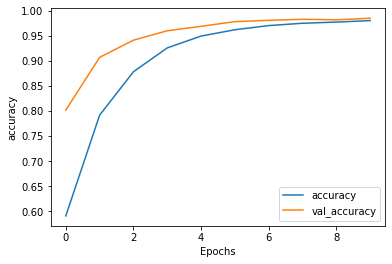

In [540]:
#Accuracy very high
plot_graphs(history, 'accuracy')

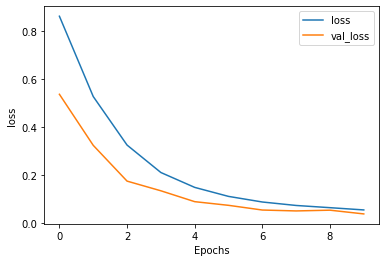

In [541]:
#Validation loss doesn't increase, so I would assume it isn't overfitted
plot_graphs(history, 'loss')

In [542]:
tftest.head()

,text
0,Last session day
1,Shanghai also really exciting precisely skyscr...
2,Recession hit Veronique Branquinho quit compan...
3,happy bday
4,like


In [543]:
print(tftest.loc[0,'text'])

Last session day


In [544]:
#Read sample submission
submission = pd.read_csv('sample_submission.csv')

In [545]:
submission.head()

,textID,sentiment
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


In [546]:
tftest.size

3534

In [547]:
for x in range(3534):
    predictions = sample_predict(tftest.loc[x,'text'], pad=True)
    
    #Assume negative has highest value
    sentiment = 'negative'
    highest = 0
    
    if predictions[0][1] > predictions[0][highest]:
        sentiment = 'neutral'
        highest = 1
    
    if predictions[0][2] > predictions[0][highest]:
        sentiment = 'positive'
        highest = 2
    
    submission.loc[x,'sentiment'] = sentiment

In [548]:
submission.head()

,textID,sentiment
0,f87dea47db,neutral
1,96d74cb729,positive
2,eee518ae67,negative
3,01082688c6,positive
4,33987a8ee5,neutral


In [549]:
#Turn submission3 to csv file, scored 0.63100 on Kaggle
submission.to_csv('submission3.csv', index=False)